In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D, LSTM, LayerNormalization, Add, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [104]:
df = pd.read_csv(r"C:\Users\lalit\OneDrive\Desktop\Research\O3 Prediction\dataset\air_quality_health_impact_data.csv")
df.head()

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,97.244041,0.0
1,2,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,100.000000,0.0
2,3,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,100.000000,0.0
3,4,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,100.000000,0.0
4,5,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,95.182643,0.0


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecordID             5811 non-null   int64  
 1   AQI                  5811 non-null   float64
 2   PM10                 5811 non-null   float64
 3   PM2_5                5811 non-null   float64
 4   NO2                  5811 non-null   float64
 5   SO2                  5811 non-null   float64
 6   O3                   5811 non-null   float64
 7   Temperature          5811 non-null   float64
 8   Humidity             5811 non-null   float64
 9   WindSpeed            5811 non-null   float64
 10  RespiratoryCases     5811 non-null   int64  
 11  CardiovascularCases  5811 non-null   int64  
 12  HospitalAdmissions   5811 non-null   int64  
 13  HealthImpactScore    5811 non-null   float64
 14  HealthImpactClass    5811 non-null   float64
dtypes: float64(11), int64(4)
memory usage:

We don't need RecordID, RespiratoryCases, CardiovascularCase, HospitalAdmissions, HealthImpactScore, HealthImpactClass as these features are related to health and does not fall under our research purview.

In [106]:
df.drop(['RecordID','RespiratoryCases','CardiovascularCases','HospitalAdmissions','HealthImpactScore','HealthImpactClass'], axis=1, inplace=True)
df.head()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed
0,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755
1,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422
2,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384
3,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500
4,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733


## Preprocessing

In [107]:
df.isnull().sum().sum()

0

In [108]:
df.duplicated().sum()

0

In [109]:
df.describe()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed
count,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000
mean,248.438476,148.654997,100.223714,102.293445,49.456838,149.312431,14.975500,54.776853,9.989177
std,144.777638,85.698500,58.096612,57.713175,28.530329,86.534240,14.483067,26.020786,5.776950
min,0.005817,0.015848,0.031549,0.009625,0.011023,0.001661,-9.990998,10.001506,0.002094
25%,122.951293,75.374954,49.435171,53.538538,24.887264,73.999665,2.481500,31.995262,4.952343
50%,249.127841,147.634997,100.506337,102.987736,49.530165,149.559871,14.942428,54.543904,10.051742
75%,373.630668,222.436759,151.340260,151.658516,73.346617,223.380126,27.465374,77.641639,14.971840
max,499.858837,299.901962,199.984965,199.980195,99.969561,299.936812,39.963434,99.997493,19.999139


We can build a scoring model to classify the O3(ppb) level into thier respective categories according to the Environmental Protection Agency(EPA) standards, which provides the following table:

| **Ozone Level (ppb)** | **Category**                         | **Description**                                  |
|-----------------------|---------------------------------------|--------------------------------------------------|
| 0–54                  | Good                                  | Air quality is satisfactory.                     |
| 55–70                 | Moderate                              | Air quality is acceptable.                       |
| 71–85                 | Unhealthy for Sensitive Groups (USG)  | Sensitive groups may experience health effects.  |
| 86–105                | Unhealthy                             | Everyone may begin to experience health effects. |
| 106–200               | Very Unhealthy                        | Health alert: Everyone may experience effects.   |
| 201+                  | Hazardous                             | Health warning of emergency conditions.          |


In [110]:
def categorize_ozone(O3):
    if O3 <= 54:
        return 'Good'
    elif O3 <= 70:
        return 'Moderate'
    elif O3 <= 85:
        return 'Unhealthy for Sensitive Groups'
    elif O3 <= 105:
        return 'Unhealthy'
    elif O3 <= 200:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['Ozone_Category'] = df['O3'].apply(categorize_ozone)

In [111]:
df.head()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,Ozone_Category
0,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,Moderate
1,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,Very Unhealthy
2,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,Good
3,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,Unhealthy
4,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,Hazardous


Now we have classified the ozone levels into their respective categories.

It's time to build a classification model

In [112]:
df.to_csv('Labelled_ozone_quality_dataset.csv', index=False)

In [113]:
df['Ozone_Category'].value_counts()

Ozone_Category
Hazardous                         1926
Very Unhealthy                    1814
Good                              1061
Unhealthy                          416
Moderate                           319
Unhealthy for Sensitive Groups     275
Name: count, dtype: int64

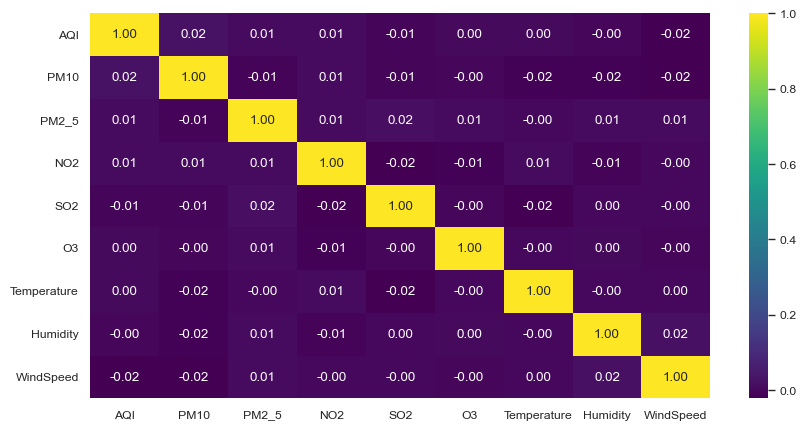

In [114]:
feature_matrix = df.drop('Ozone_Category', axis=1)
corr_matrix = feature_matrix.corr()

sns.set_context('paper')
sns.set_style('dark')

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, cmap='viridis', fmt='.2f', annot=True)
plt.show()

In [115]:
encoder = LabelEncoder()
df['Ozone_Category'] = encoder.fit_transform(df['Ozone_Category'])
encoder.classes_

array(['Good', 'Hazardous', 'Moderate', 'Unhealthy',
       'Unhealthy for Sensitive Groups', 'Very Unhealthy'], dtype=object)

- 0 - Good
- 1 - Hazardous
- 2 - Moderate
- 3 - Unhealthy
- 4 - Unhealthy for Sensitive Groups
- 5 - Very Unhealthy

## Building the Model

In [116]:
X = feature_matrix
y = df['Ozone_Category']

In [117]:
y.value_counts(normalize=True)

Ozone_Category
1    0.331440
5    0.312167
0    0.182585
3    0.071588
2    0.054896
4    0.047324
Name: proportion, dtype: float64

In [20]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=0)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp, random_state=0)

### KNN

In [18]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],           # Number of neighbors
    'weights': ['uniform', 'distance'],         # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,
                    verbose=1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [19]:
knn_grid.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

In [20]:
print(f"Accuracy Score: {accuracy_score(y_test, knn_grid.predict(X_test))}")

Accuracy Score: 0.8529664660361135


In [21]:
from sklearn.metrics import precision_recall_fscore_support

def metrics(y_test, y_pred):
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    return precision, recall, fscore

metrics(y_test, knn_grid.predict(X_test))

(0.7253245498834334, 0.6399009277942883, 0.6605408518604023)

In [22]:
results = []
def evaluate_metrics(model_name, model, X_test, y_test):
    score = accuracy_score(y_test, model.predict(X_test))
    results.append([model_name, f"{score*100}%", classification_report(y_test, model.predict(X_test)), confusion_matrix(y_test, model.predict(X_test))])
    return results

In [23]:
evaluate_metrics('KNN', knn_grid, X_test, y_test)

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)]]

### Logistic Regression with OneVsRestClassifier

In [24]:
from sklearn.multiclass import OneVsRestClassifier

In [25]:
logReg = LogisticRegression()

ovr = OneVsRestClassifier(logReg)
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],          # Regularization parameter
    'estimator__solver': ['liblinear', 'saga'],   # Solvers for optimization
    'estimator__penalty': ['l1'],                 # Regularization type
    'estimator__max_iter': [1000, 2000]           # Number of iterations for convergence
}

log_grid = GridSearchCV(estimator=ovr,
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        verbose=1)
log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': [0.01, 0.1, 1, 10],
                         'estimator__max_iter': [1000, 2000],
                         'estimator__penalty': ['l1'],
                         'estimator__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [26]:
metrics(y_test, log_grid.predict(X_test))

(0.4398766653838401, 0.49954086317722685, 0.4632867271119447)

In [27]:
evaluate_metrics('Logistic', log_grid, X_test, y_test)

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)],
 ['Logistic',
  '82.5451418744626%',
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     

### Decision Tree

In [28]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                       param_grid=param_grid,
                       scoring='accuracy',
                       verbose=1,
                       cv=5)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [29]:
metrics(y_test, dt_grid.predict(X_test))

(1.0, 1.0, 1.0)

In [30]:
evaluate_metrics('Decision Tree', dt_grid, X_test, y_test)

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)],
 ['Logistic',
  '82.5451418744626%',
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     

### Random Forest (Ensembling)

In [31]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],     # Maximum depth of the tree
    'max_features': ['auto', 'sqrt', 'log2'],    # The number of features to consider when looking for the best split
}

rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                       param_grid=param_grid,
                       scoring='accuracy',
                       verbose=1,
                       cv=5)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy', verbose=1)

In [32]:
metrics(y_test, rf_grid.predict(X_test))

(1.0, 1.0, 1.0)

In [33]:
evaluate_metrics('Random Forest', rf_grid, X_test, y_test)

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)],
 ['Logistic',
  '82.5451418744626%',
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     

### Artificial Neural Network(Multi-Layered Perceptron)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=1000, random_state=27108)
mlp_classifier.fit(X_train_scaled, y_train)

MLPClassifier(max_iter=1000, random_state=27108)

In [36]:
X_test_scaled = scaler.transform(X_test)
metrics(y_test, mlp_classifier.predict(X_test_scaled))

(0.9534966024043955, 0.9557122668208372, 0.954497277221245)

In [37]:
evaluate_metrics('ANN', mlp_classifier, X_test_scaled, y_test)

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)],
 ['Logistic',
  '82.5451418744626%',
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     

### Convolutional Neural Networks(CNN)

In [39]:
cnn_model = Sequential()

# Add a 1D convolution layer
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=(X_train.shape[1], 1), kernel_regularizer=l1(0.05)))

# Add a max pooling layer
cnn_model.add(MaxPooling1D(pool_size=2))

# Add Dropout after the convolution + pooling block
cnn_model.add(Dropout(0.3))  # Dropout 30% of the neurons

# Flatten the output from the convolution layer
cnn_model.add(Flatten())

# Add a fully connected layer
cnn_model.add(Dense(64, activation='relu'))

# Add Dropout after the fully connected layer
cnn_model.add(Dropout(0.5))  # Dropout 50% of the neurons

# Output layer (for multi-class classification)
cnn_model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_scaled, y_train, epochs=500, batch_size=100, validation_data=(X_test, y_test))

# Make predictions on the test set
y_pred = cnn_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3556 - loss: 2.3670 - val_accuracy: 0.3319 - val_loss: 62.7304
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5198 - loss: 1.7572 - val_accuracy: 0.3319 - val_loss: 67.6692
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5704 - loss: 1.4977 - val_accuracy: 0.3319 - val_loss: 65.4616
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5953 - loss: 1.3394 - val_accuracy: 0.3319 - val_loss: 70.6185
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6069 - loss: 1.2662 - val_accuracy: 0.3319 - val_loss: 73.8257
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6135 - loss: 1.2287 - val_accuracy: 0.3319 - val_loss: 83.8001
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6215 - loss: 1.1996 - val_accuracy: 0.3319 - val_loss: 85.8650
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6263 - loss: 1.1712 - val_accuracy: 0.3

In [40]:
scores = cnn_model.evaluate(X_test_scaled, y_test)
scores

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8806 - loss: 0.4060 


[0.40495622158050537, 0.8830610513687134]

In [41]:
score = accuracy_score(y_test, y_pred_classes)
cf_report = classification_report(y_test, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)

results.append(['CNN', f"{score*100}%", cf_report, cm])

In [42]:
results

[['KNN',
  '85.29664660361135%',
  '              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88       212\n           1       0.96      0.98      0.97       386\n           2       0.54      0.30      0.38        64\n           3       0.62      0.42      0.50        83\n           4       0.57      0.24      0.33        55\n           5       0.85      0.95      0.90       363\n\n    accuracy                           0.85      1163\n   macro avg       0.73      0.64      0.66      1163\nweighted avg       0.83      0.85      0.83      1163\n',
  array([[203,   0,   7,   1,   1,   0],
         [  0, 378,   0,   0,   0,   8],
         [ 37,   0,  19,   4,   3,   1],
         [  0,   0,   1,  35,   6,  41],
         [ 12,   0,   8,  12,  13,  10],
         [  0,  15,   0,   4,   0, 344]], dtype=int64)],
 ['Logistic',
  '82.5451418744626%',
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     

In [43]:
import csv
headers = ['Model', 'Accuracy', 'Classification Report', 'Confusion Matrix']
with open('results.csv', 'w', newline='') as file:
    csvWriter = csv.writer(file)
    csvWriter.writerow(headers)
    csvWriter.writerows(results)

## ROC for ANN

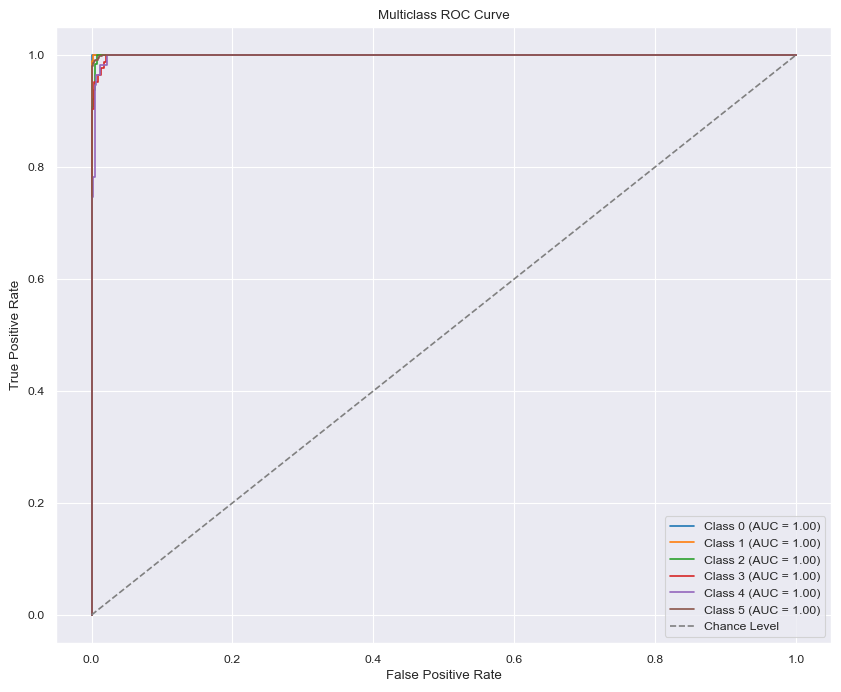

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels (One-vs-Rest)
classes = np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)
y_prob = mlp_classifier.predict_proba(X_test_scaled)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Add diagonal line for random chance
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## ROC for New CNN Model

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


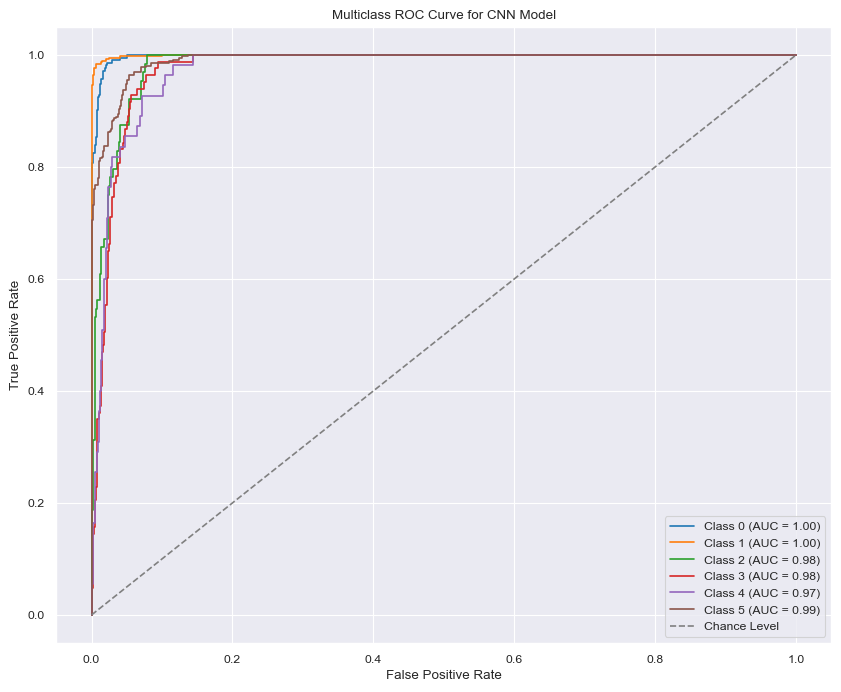

In [45]:
classes = np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)

# Get predicted probabilities for each class
y_prob = cnn_model.predict(X_test_scaled)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for CNN Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# LSTM with SMOTE

In [169]:
y_resampled.value_counts(normalize=True)

Ozone_Category
2    0.166667
5    0.166667
0    0.166667
3    0.166667
1    0.166667
4    0.166667
Name: proportion, dtype: float64

In [170]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [171]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [172]:
y_resampled.value_counts()

Ozone_Category
2    1926
5    1926
0    1926
3    1926
1    1926
4    1926
Name: count, dtype: int64

In [121]:
y_resampled_categorical = to_categorical(y_resampled)

In [122]:
X_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled_categorical, test_size=0.2, random_state=42)

In [176]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_reshaped.shape[1], 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_resampled_categorical.shape[1], activation='softmax'))

In [177]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [178]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [181]:
lstm_history = model.fit(X_train, 
                         y_train,
                         validation_data=(X_test, y_test),
                         epochs=50, 
                         batch_size=32,
                         callbacks=[early_stop, reduce_lr])

Epoch 1/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3474 - loss: 1.4687 - val_accuracy: 0.5800 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6545 - loss: 0.7929 - val_accuracy: 0.9299 - val_loss: 0.2942 - learning_rate: 0.0010
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8123 - loss: 0.4469 - val_accuracy: 0.9334 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8369 - loss: 0.3905 - val_accuracy: 0.9416 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8739 - loss: 0.3197 - val_accuracy: 0.9477 - val_loss: 0.1616 - learning_rate: 0.0010
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8852 - loss: 0.2880 - val_accuracy: 0.9641 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8969 - loss: 0.2642 - 

In [182]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0197
Test Accuracy: 0.99


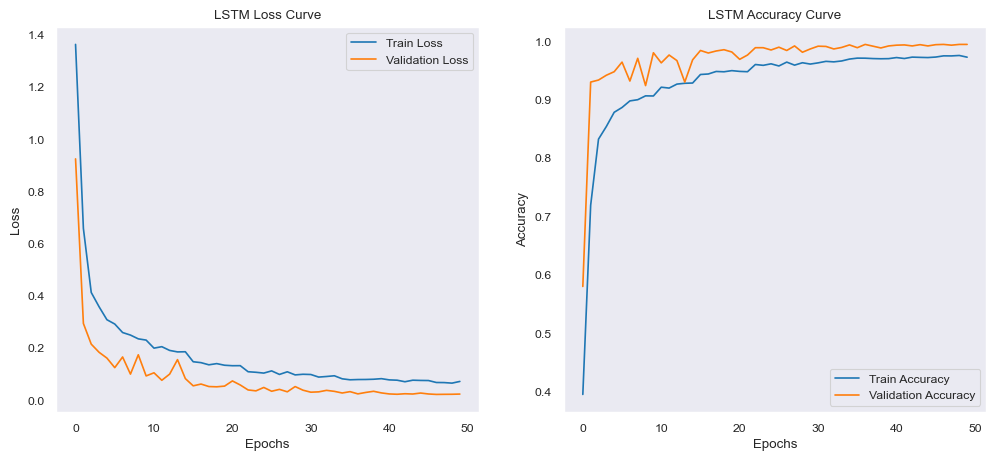

In [184]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
# Loss curve
axes[0].plot(lstm_history.history['loss'], label='Train Loss')
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'LSTM Loss Curve')
axes[0].legend()

# Accuracy curve
axes[1].plot(lstm_history.history['accuracy'], label='Train Accuracy')
axes[1].plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'LSTM Accuracy Curve')
axes[1].legend()

plt.show()

In [185]:
lstm_y_pred = model.predict(X_test)
lstm_y_pred_classes = np.argmax(lstm_y_pred, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Accuracy - 0.9943771626297578%

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       393
           1       1.00      0.99      1.00       388
           2       0.99      1.00      0.99       397
           3       0.99      0.99      0.99       382
           4       0.99      1.00      1.00       373
           5       0.99      0.99      0.99       379

    accuracy                           0.99      2312
   macro avg       0.99      0.99      0.99      2312
weighted avg       0.99      0.99      0.99      2312



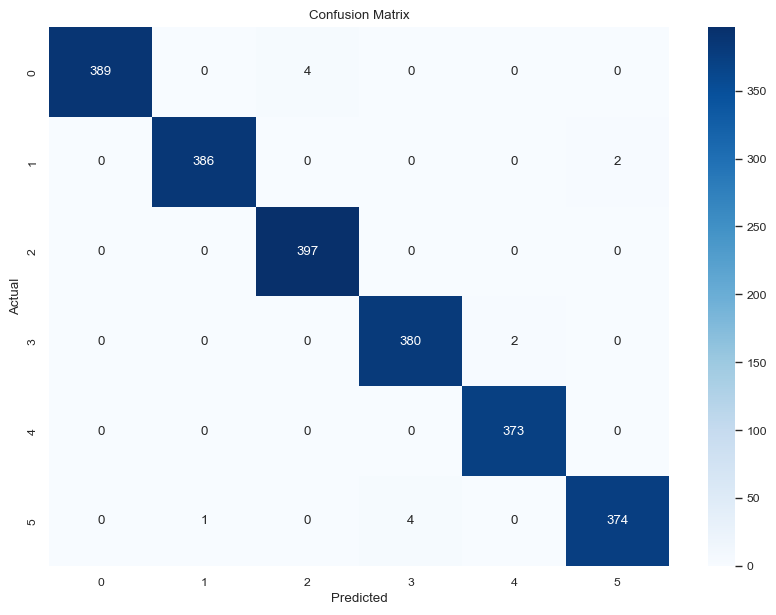

In [187]:
lstm_score = accuracy_score(y_test_labels, lstm_y_pred_classes)
lstm_cf_report = classification_report(y_test_labels, lstm_y_pred_classes)
lstm_cm = confusion_matrix(y_test_labels, lstm_y_pred_classes)

print(f"Accuracy - {lstm_score}%")
print(f"\nClassification Report\n{lstm_cf_report}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC for LSTM

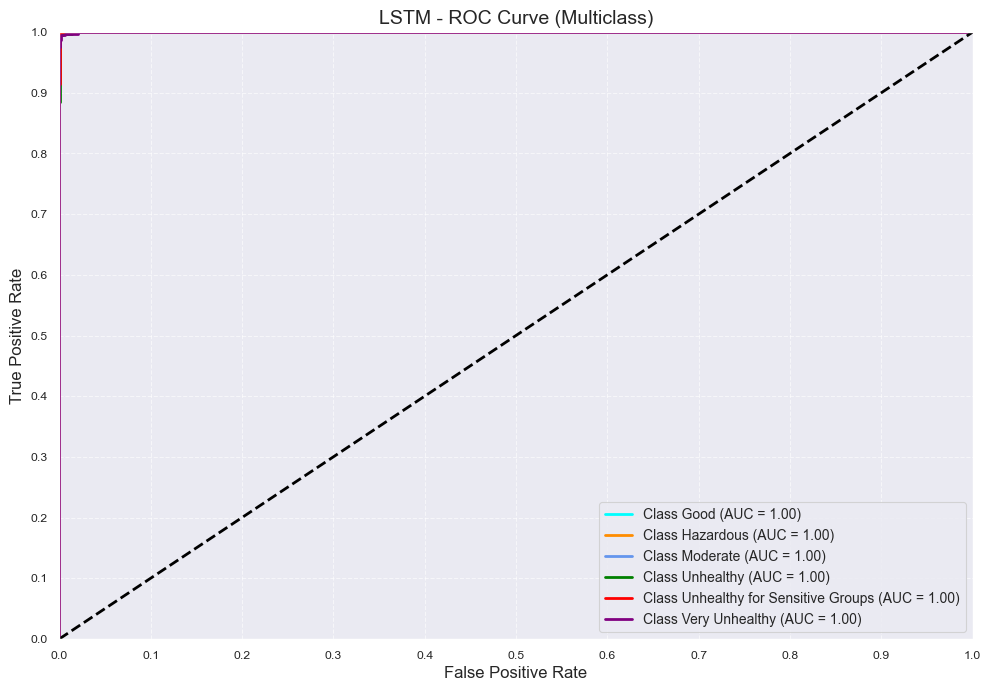

In [188]:
# y_test is already one-hot encoded
n_classes = y_test.shape[1]
y_test_bin = y_test
y_score = lstm_y_pred

# ROC computation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot with better tick intervals and LabelEncoder class names
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    class_label = encoder.inverse_transform([i])[0]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal

# Remove ticks entirely for better visibility
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('LSTM - ROC Curve (Multiclass)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Bi-Directional LSTM

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Label encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 3. One-hot encode labels
y_train_encoded = np.eye(len(le.classes_))[y_train_encoded]
y_test_encoded = np.eye(len(le.classes_))[y_test_encoded]

# 4. Convert X_train and X_test to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

In [129]:
# 5. Apply SMOTE on flattened training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_array, y_train_encoded)

In [130]:
# 6. Reshape for LSTM input: (samples, timesteps, features)
n_timesteps = 1
n_features = X.shape[1]

X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], n_timesteps, n_features)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], n_timesteps, n_features)

In [133]:
# 7. Define BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(len(le.classes_), activation='softmax'))

# 8. Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [134]:
# 9. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [135]:
# 10. Train model
bi_lstm_history = model.fit(
    X_train_smote, 
    y_train_smote,
    validation_data=(X_test_reshaped, y_test_encoded),
    epochs=100, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4178 - loss: 1.4224 - val_accuracy: 0.7163 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 0.7736 - val_accuracy: 0.7420 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6945 - loss: 0.7101 - val_accuracy: 0.7713 - val_loss: 0.5535 - learning_rate: 0.0010
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7287 - loss: 0.6599 - val_accuracy: 0.7670 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7312 - loss: 0.6363 - val_accuracy: 0.7601 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7521 - loss: 0.6045 - val_accuracy: 0.7782 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7493 - loss: 0.

In [136]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.5618
Test Loss: 0.5278
Test Accuracy: 0.7876


In [137]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       237
           1       0.85      0.92      0.88       365
           2       0.52      0.63      0.57        71
           3       0.47      0.48      0.48        92
           4       0.37      0.43      0.40        51
           5       0.82      0.74      0.78       347

    accuracy                           0.79      1163
   macro avg       0.67      0.68      0.67      1163
weighted avg       0.80      0.79      0.79      1163



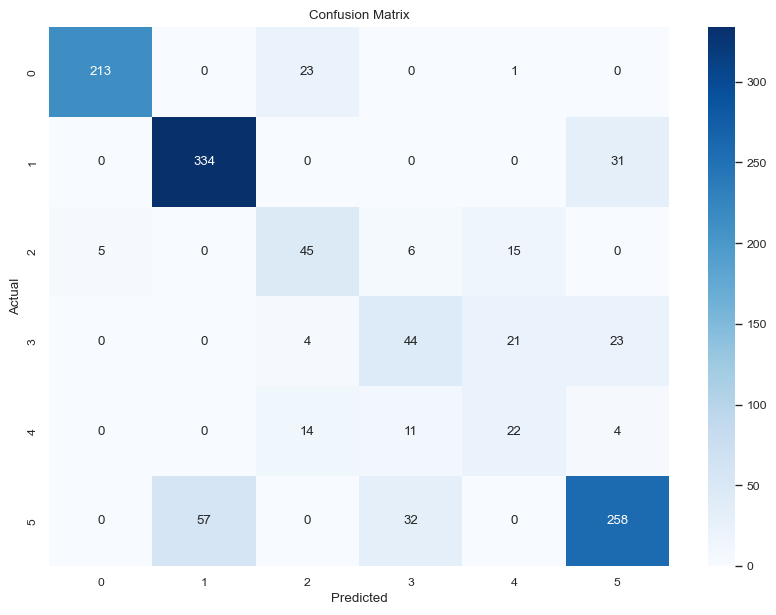

In [139]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

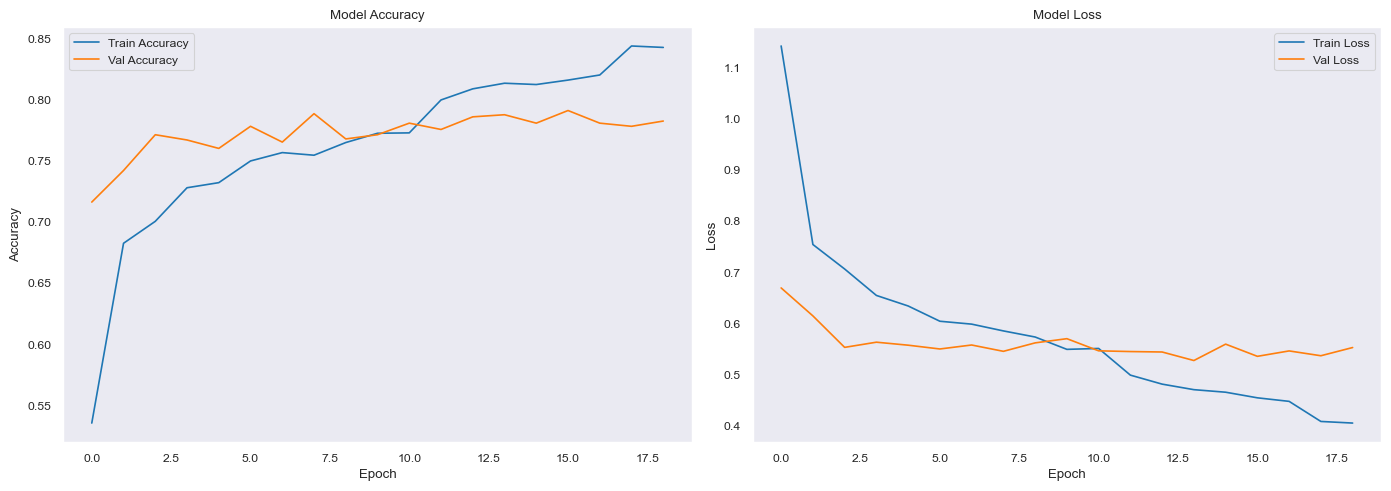

In [140]:
# Plot accuracy and loss curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(bi_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(bi_lstm_history.history['loss'], label='Train Loss')
plt.plot(bi_lstm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ROC for Bi-LSTM

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


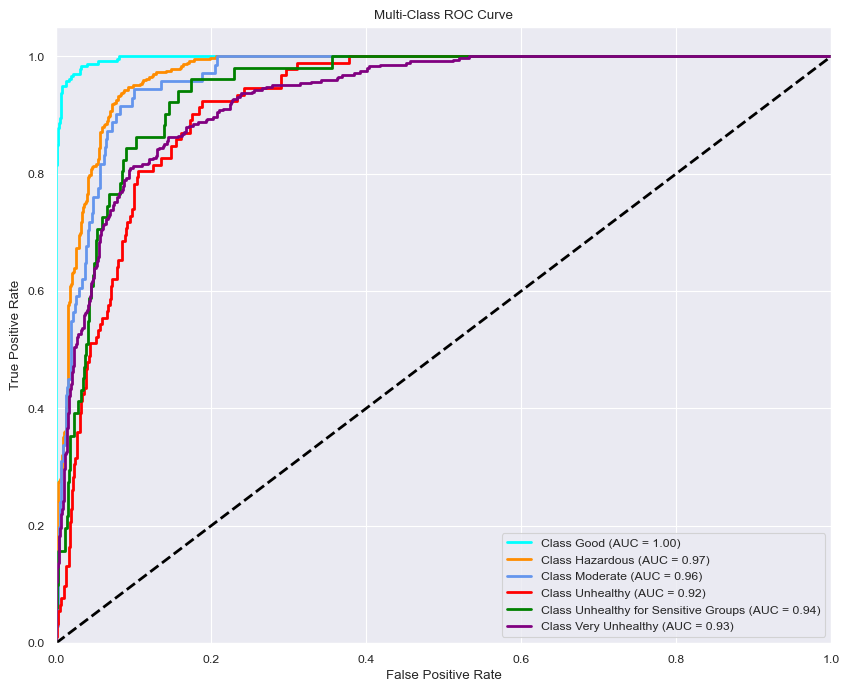

In [164]:
# Ensure y_true and y_pred_probs are correctly defined
y_true = y_test  # True labels (already encoded)
y_pred_probs = model.predict(X_test_reshaped)  # Predicted probabilities

# Binarize true labels for ROC using label_binarize with class names from LabelEncoder
y_true_bin = label_binarize(y_true, classes=le.classes_)

n_classes = y_true_bin.shape[1]  # Number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'navy', 'olive'])

# Manually specify class names for legend
class_names = ['Good', 'Hazardous', 'Moderate', 'Unhealthy', 'Unhealthy for Sensitive Groups', 'Very Unhealthy']  # Ensure class names are in string format

# Iterate through all classes and plot the ROC curve with manually specified class names
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")  # Use manually specified class names

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Final formatting for the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Hybrid - CNN + BiLSTM + Attention

In [119]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [120]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [25]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

In [29]:
# X_train = X_train[..., tf.newaxis]
# X_val = X_val[..., tf.newaxis]
# X_test = X_test[..., tf.newaxis]

In [30]:
input_shape = X_train.shape[1:]

In [31]:
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionBlock, self).__init__()
        self.attention = Attention()
        self.layernorm = LayerNormalization()

    def call(self, query, value):
        attn_output = self.attention([query, value])
        out = Add()([query, attn_output])  # Skip connection
        out = self.layernorm(out)
        return out

In [34]:
inputs = Input(shape=input_shape)

In [70]:
# CNN layers
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

In [71]:
# BiLSTM layer
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Use Lambda layer to reshape the output to 3D for Attention (timesteps = 1)
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # (batch_size, 1, features)

In [72]:
# Attention layer
attention_block = AttentionBlock()
x = attention_block(x, x)

In [73]:
# Fully Connected Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [74]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 9, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 9, 64)             │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_12              │ (None, 4, 64)             │               0 │ conv1d_12[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_13 (Conv1D)            │ (None, 4, 128)            │          24,704 │ max_pooling1d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_13              │ (None, 2, 128)            │               0 │ conv1d_13[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_8               │ (None, 128)               │          98,816 │ max_pooling1d_13[0][0]     │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 1, 128)            │               0 │ bidirectional_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_block_4             │ (None, 1, 128)            │             256 │ lambda[0][0], lambda[0][0] │
│ (AttentionBlock)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1, 128)            │          16,512 │ attention_block_4[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 1, 128)            │               0 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 1, 64)             │           8,256 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 1, 64)             │               0 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 1, 6)              │             390 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 149,190 (582.77 KB)

 Trainable params: 149,190 (582.77 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3895 - loss: 1.5236 - val_accuracy: 0.6333 - val_loss: 0.8571
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6699 - loss: 0.8703 - val_accuracy: 0.7677 - val_loss: 0.5333
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7400 - loss: 0.6545 - val_accuracy: 0.8086 - val_loss: 0.4279
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7983 - loss: 0.5120 - val_accuracy: 0.8419 - val_loss: 0.4002
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8096 - loss: 0.4591 - val_accuracy: 0.8075 - val_loss: 0.4126
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8361 - loss: 0.3854 - val_accuracy: 0.8570 - val_loss: 0.3332
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8129 - loss: 0.4368 - val_accuracy: 0.8871 - val_loss: 0.2666
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8611 - loss: 0.3262 - val_accuracy: 0

In [76]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss - {loss}\nAccuracy - {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9116 - loss: 0.2638
Loss - 0.25237077474594116
Accuracy - 0.9157351851463318


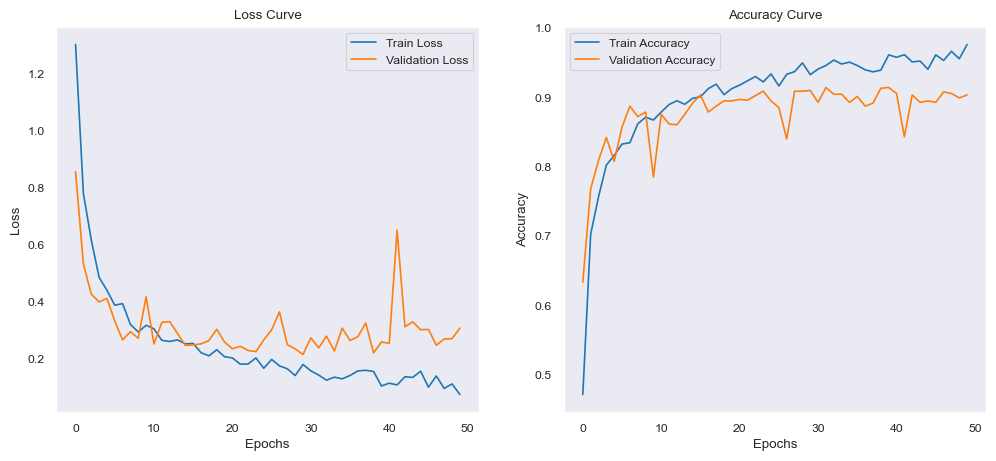

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
# Loss curve
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Loss Curve')
axes[0].legend()

# Accuracy curve
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Accuracy Curve')
axes[1].legend()

plt.show()

In [100]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [101]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.18      1.00      0.31       212
           1       0.00      0.00      0.00       386
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        83
           4       0.00      0.00      0.00        55
           5       0.00      0.00      0.00       363

    accuracy                           0.18      1163
   macro avg       0.03      0.17      0.05      1163
weighted avg       0.03      0.18      0.06      1163



# Hybrid Finetuning

In [136]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the K-fold cross-validation parameters
k = 5  # Number of folds (you can change this)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# List to store performance metrics for each fold
val_accuracies = []
val_losses = []

# Start K-Fold Cross Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"\nTraining Fold {fold + 1}/{k}")
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Define the model (same as before)
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (9, 1)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    attention_layer = Attention()([x, x])
    x = Add()([x, attention_layer])
    x = GlobalAveragePooling1D()(x)
    output_layer = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    # Fit the model
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss for Fold {fold + 1}: {val_loss:.4f}")
    print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}")

# Average performance across all folds
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"\nAverage Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")



Training Fold 1/5
Restoring model weights from the end of the best epoch: 8.
Validation Loss for Fold 1: 0.2306
Validation Accuracy for Fold 1: 0.9091

Training Fold 2/5
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
Validation Loss for Fold 2: 0.2829
Validation Accuracy for Fold 2: 0.8967

Training Fold 3/5
Restoring model weights from the end of the best epoch: 10.
Validation Loss for Fold 3: 0.1800
Validation Accuracy for Fold 3: 0.9351

Training Fold 4/5
Restoring model weights from the end of the best epoch: 9.
Validation Loss for Fold 4: 0.2174
Validation Accuracy for Fold 4: 0.9102

Training Fold 5/5
Restoring model weights from the end of the best epoch: 9.
Validation Loss for Fold 5: 0.1955
Validation Accuracy for Fold 5: 0.9318

Average Validation Loss: 0.2213
Average Validation Accuracy: 0.9166


In [137]:
# Define final model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
attention_layer = Attention()([x, x])
x = Add()([x, attention_layer])
x = GlobalAveragePooling1D()(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output_layer)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit on the full training data
final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2669 - loss: 1.6817
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6190 - loss: 0.9411
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8057 - loss: 0.5194
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8402 - loss: 0.4127
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8822 - loss: 0.3084
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9005 - loss: 0.2590
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9003 - loss: 0.2464
Epoch 8/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9143 - loss: 0.2129
Epoch 9/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9145 - loss: 0.2106
Epoch 10/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9310 - loss: 0.1701
Epoch 11/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9374 - loss: 0.1613
Epoch 12/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

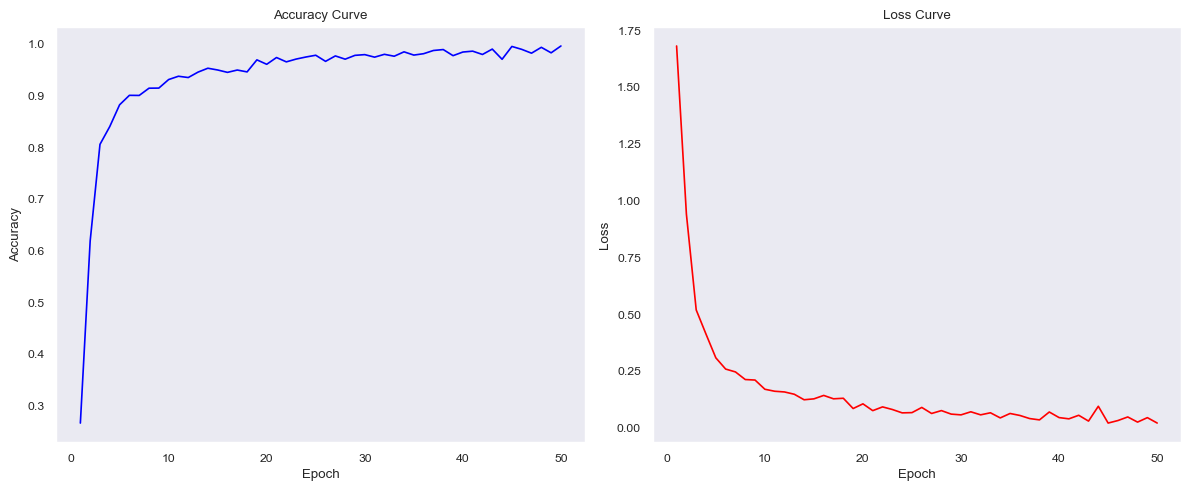

In [143]:
epochs = list(range(1, 51))
accuracy = [
    0.2669, 0.6190, 0.8057, 0.8402, 0.8822, 0.9005, 0.9003, 0.9143, 0.9145, 0.9310,
    0.9374, 0.9349, 0.9454, 0.9529, 0.9495, 0.9449, 0.9494, 0.9458, 0.9691, 0.9605,
    0.9736, 0.9652, 0.9706, 0.9746, 0.9780, 0.9662, 0.9767, 0.9704, 0.9778, 0.9792,
    0.9743, 0.9798, 0.9761, 0.9846, 0.9783, 0.9810, 0.9872, 0.9890, 0.9772, 0.9842,
    0.9859, 0.9795, 0.9899, 0.9702, 0.9950, 0.9894, 0.9820, 0.9933, 0.9827, 0.9959
]
loss = [
    1.6817, 0.9411, 0.5194, 0.4127, 0.3084, 0.2590, 0.2464, 0.2129, 0.2106, 0.1701,
    0.1613, 0.1582, 0.1481, 0.1238, 0.1278, 0.1429, 0.1280, 0.1304, 0.0852, 0.1058,
    0.0759, 0.0924, 0.0809, 0.0661, 0.0672, 0.0900, 0.0634, 0.0761, 0.0606, 0.0573,
    0.0708, 0.0574, 0.0665, 0.0439, 0.0634, 0.0547, 0.0410, 0.0352, 0.0699, 0.0453,
    0.0398, 0.0555, 0.0299, 0.0952, 0.0212, 0.0323, 0.0481, 0.0254, 0.0451, 0.0213
]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, color='blue')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [138]:
# Predict probabilities
y_pred_prob = final_model.predict(X_test)

# Get class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [139]:
y_true = np.argmax(y_test, axis=1)

In [140]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       393
           1       0.92      0.99      0.96       388
           2       0.98      1.00      0.99       397
           3       0.96      0.97      0.96       382
           4       0.97      0.99      0.98       373
           5       0.99      0.87      0.93       379

    accuracy                           0.97      2312
   macro avg       0.97      0.97      0.97      2312
weighted avg       0.97      0.97      0.97      2312



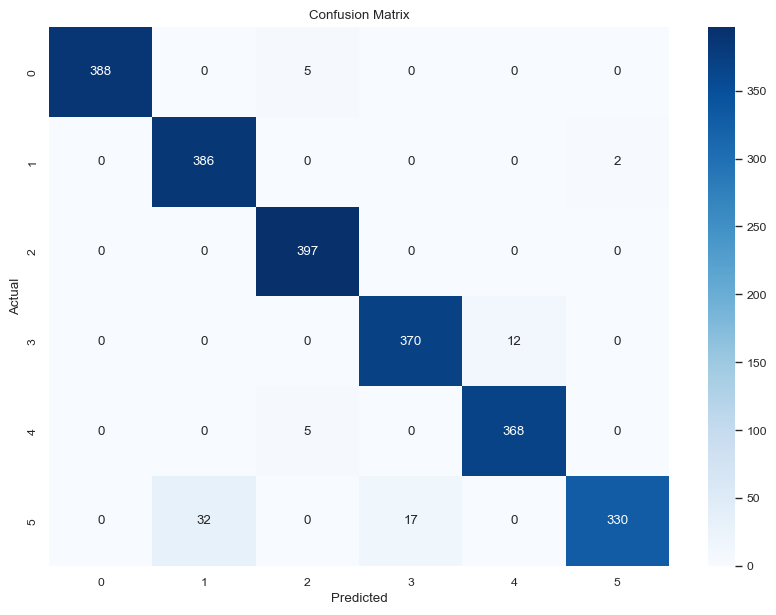

In [141]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

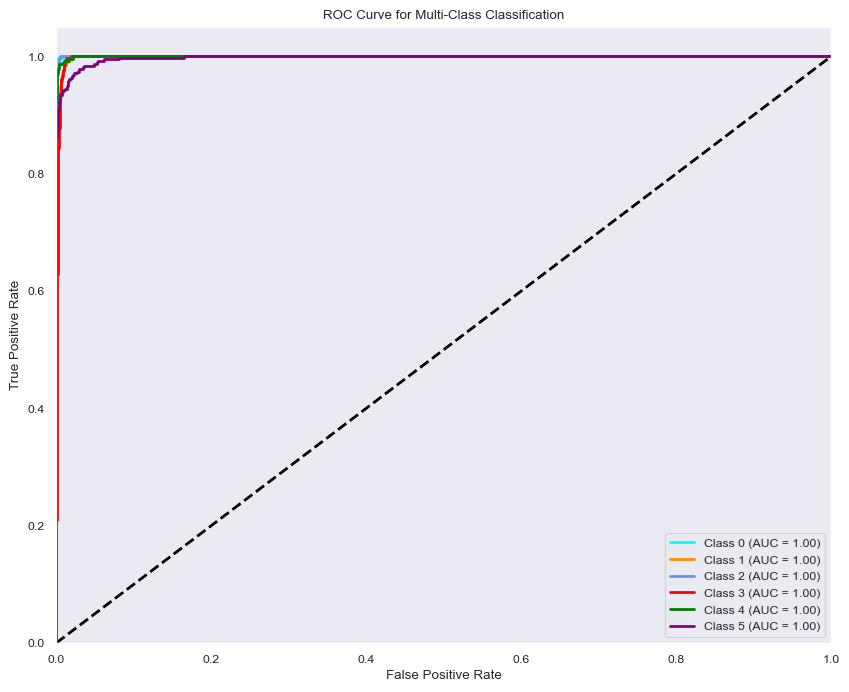

In [142]:
# Binarize y_true (convert to one-hot if not already)
n_classes = y_test.shape[1]  # should be 6

# y_true is already one-hot if it's y_test
# But we converted y_test -> y_true = np.argmax(y_test, axis=1)
# So, we need to rebinarize:
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


# SHAP/LIME plots and Attention Weight Analysis

In [144]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   -------------------------------------- - 524.3/545.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 545.2/545.2 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.8 MB 1.8 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 1.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.9 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.9 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 1.8 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 1.8 MB/s eta 0:00:01
   ---------------------


[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ExactExplainer explainer: 11it [00:22,  2.48s/it]                                                                      


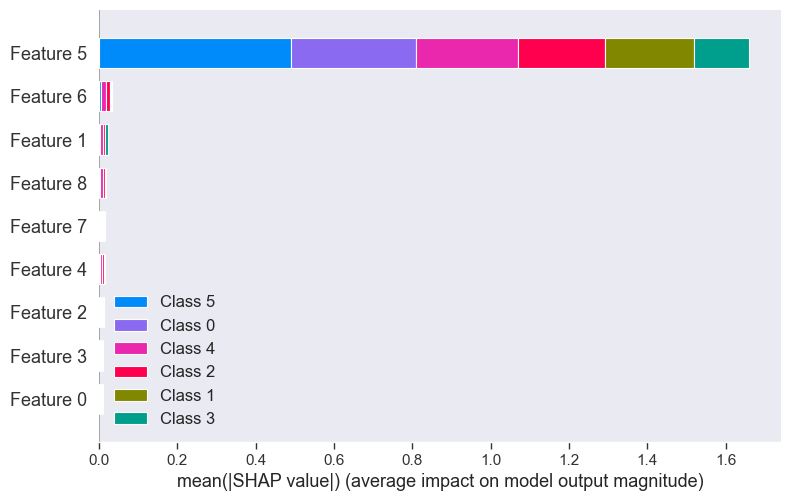

In [150]:
import shap
import numpy as np

# Squeeze to 2D
X_train_2d = X_train.squeeze(-1)
X_test_2d = X_test.squeeze(-1)

# Random background sample
background = X_train_2d[np.random.choice(X_train_2d.shape[0], 100, replace=False)]

# Create masker
masker = shap.maskers.Independent(background)

# Create explainer
explainer = shap.Explainer(final_model, masker)

# Explain first 10 samples
shap_values = explainer(X_test_2d[:10])

# Plot summary
shap.summary_plot(shap_values, features=X_test_2d[:10])


In [163]:
# Attentiona Weigths
import keras
# Assuming you named your attention layer as 'attention_layer' during model creation
attention_extractor = keras.Model(inputs=final_model.input,
                                  outputs=final_model.get_layer('attention_16').output)

# Get attention weights for some samples
attention_weights = attention_extractor.predict(X_test[:10])

print(attention_weights.shape)  # (num_samples, sequence_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
(10, 4, 128)


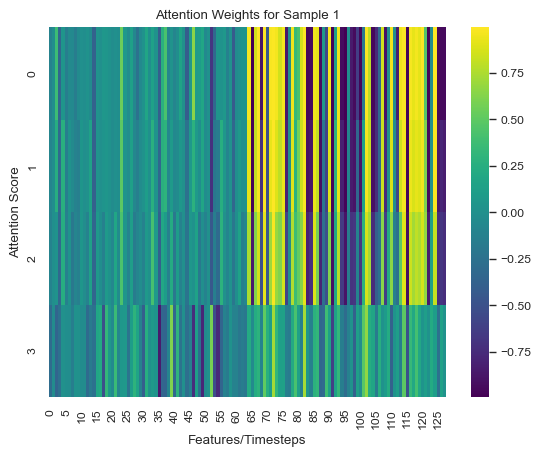

In [164]:
sns.heatmap(attention_weights[0], cmap="viridis")
plt.title('Attention Weights for Sample 1')
plt.xlabel('Features/Timesteps')
plt.ylabel('Attention Score')
plt.show()

---